#### `Read/Extract Data from JSON files`

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pandas as pd
# Your extract() function here
# Your transform() function here
# :arrow_down: Paste load() function here
def load(customer_df):
    print("Loading data into MySQL...")
    # Use the existing customer_df, mysql_url, and mysql_properties variables

    # customer_df.write \
    #     .format("jdbc") \
    #     .option("url", mysql_url) \
    #     .option("dbtable", "cdw_sapp_customer") \
    #     .option("user", mysql_properties["user"]) \
    #     .option("password", mysql_properties["password"]) \
    #     .option("driver", mysql_properties["driver"]) \
    #     .mode("append") \
    #     .save()
    
    print(":white_check_mark: Data loaded successfully.")

# Export customer_df to CSV (as Pandas DataFrame)
#customer_pd = customer_df.toPandas()
#customer_pd.to_csv('transformed_customer_data.csv', index=False)

customer_pd=pd.read_json(r"C:\Users\cdw_sapp_customer.json") # Read JSON file into DataFrame
# Display the top 20 rows
print(customer_pd.head(20))

customer_pd=pd.read_json(r"C:\Users\cdw_sapp_customer.json") # Read JSON file into DataFrame


# Use pd.to_datetime function to create a datetime column from YEAR, MONTH, DAY columns
credit_df = pd.read_json(r"C:\Users\cdw_sapp_credit.json")  # read JSON file into DataFrame
credit_df['TIMEID'] = pd.to_datetime(credit_df[['YEAR', 'MONTH', 'DAY']]) # Converted each day, year, and month into TIMEID 

credit_df.drop(['DAY', 'MONTH', 'YEAR'], axis=1, inplace=True) # Dropped the original columns
 
print(credit_df.head(20)) # Printed the first 20 rows. 

# Step 8: Read branch JSON file into DataFrame
branch_df = pd.read_json(r"C:\Users\cdw_sapp_branch.json")

# Convert BRANCH_PHONE column to string type, then pad zeros on the left to length 10 using str.zfill
branch_df['BRANCH_PHONE'] = branch_df['BRANCH_PHONE'].astype(str).str.zfill(10)

# Use apply + lambda to format phone numbers (string slicing and f-string formatting)
branch_df['BRANCH_PHONE'] = branch_df['BRANCH_PHONE'].apply(lambda x: f"({x[0:3]}){x[3:6]}-{x[6:]}")

# Print the first 20 rows of branch_df DataFrame
print(branch_df.head(20)) 


   FIRST_NAME MIDDLE_NAME  LAST_NAME        SSN    CREDIT_CARD_NO  APT_NO  \
0        Alec          Wm     Hooper  123456100  4210653310061055     656   
1        Etta     Brendan     Holman  123453023  4210653310102868     829   
2      Wilber    Ezequiel     Dunham  123454487  4210653310116272     683   
3     Eugenio       Trina      Hardy  123459758  4210653310195948     253   
4     Wilfred         May      Ayers  123454431  4210653310356919     301   
5        Beau     Ambrose    Woodard  123454202  4210653310395982       3   
6      Sheila       Larry       Kemp  123451799  4210653310400536      84   
7       Wendy         Ora     Hurley  123453875  4210653310459911     728   
8        Alec      Tracie    Gilmore  123457511  4210653310773972      81   
9      Barbra     Mitchel        Lau  123457464  4210653310794854     561   
10    Edmundo       Denny    Thomson  123457639  4210653310817373     622   
11       Elsa    Isabelle     Truong  123453242  4210653310844617     924   

#### `Loading Data Into Database`

In [2]:
from pyspark.sql import SparkSession # Imported libraries 
# Creating a spark session
spark = SparkSession.builder \
    .appName("TestMySQLConnection") \
    .config("spark.jars", r"C:\path\to\mysql-connector-java-8.0.33.jar") \
    .getOrCreate()

# MySQL database connection
mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
# Connection properties
mysql_properties = {
    "user": "root",       
    "password": "password",  
    "driver": "com.mysql.cj.jdbc.Driver"
}


In [3]:
# Reads a JSON file into a spark df 
branch_df = spark.read.json( 
    # The r string makes it a raw string, so the backslashes aren't treated as escape characters. 
    r"C:\Users\cdw_sapp_branch.json",
    # Tells spark the JSON file contains one or more records spanning multiple lines. 
    multiLine=True
)

credit_df = spark.read.json(
    r"C:\Users\cdw_sapp_credit.json",
    multiLine=True
)

customer_df = spark.read.json(
    r"C:\Users\cdw_sapp_customer.json",
    multiLine=True
)


In [4]:
branch_df.printSchema()
branch_df.show(5, truncate=False)

credit_df.printSchema() 
credit_df.show(5, truncate=False)

customer_df.printSchema() 
customer_df.show(5, truncate=False)

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|BRANCH_CITY      |BRANCH_CODE|BRANCH_NAME |BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET    |BRANCH_ZIP|LAST_UPDATED                 |
+-----------------+-----------+------------+------------+------------+-----------------+----------+-----------------------------+
|Lakeville        |1          |Example Bank|1234565276  |MN          |Bridle Court     |55044     |2018-04-18T16:51:47.000-04:00|
|Huntley          |2          |Example Bank|1234618993  |IL          |Washington Street|60142     |2018-04-18T16:51:47.000-04:00|


In [5]:
from pyspark.sql.functions import length, max
customer_df.select(max(length("CUST_EMAIL"))).show()

from pyspark.sql.functions import length, max
customer_df.select(max(length("CUST_EMAIL"))).show()

+-----------------------+
|max(length(CUST_EMAIL))|
+-----------------------+
|                     26|
+-----------------------+

+-----------------------+
|max(length(CUST_EMAIL))|
+-----------------------+
|                     26|
+-----------------------+



In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType, StringType
from pyspark.sql.functions import col, sum
def init_spark(app_name, jar_path):
    return SparkSession.builder \
        .appName(app_name) \
        .config("spark.jars", jar_path) \
        .getOrCreate()
def load_json_with_schema(spark, file_path, schema=None):
    if schema:
        return spark.read.json(file_path, schema=schema)
    else:
        return spark.read.json(file_path, multiLine=True)
def write_to_mysql(df, table_name, mysql_url, props):
    df.write.jdbc(url=mysql_url, table=table_name, mode="append", properties=props)
def check_nulls(df):
    df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
def check_duplicates(df, key):
    df.groupBy(key).count().filter("count > 1").show()
def main():
    spark = init_spark("CreditCardCapstone", r"C:\Spark\jars\mysql-connector-java-8.0.33.jar")
    # Define MySQL connection
    mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
    mysql_props = {"user": "root", "password": "password", "driver": "com.mysql.cj.jdbc.Driver"}


    # Define schema for customer


#     Customer DataFrame Schema:
# root
#  |-- APT_NO: string (nullable = true)
#  |-- CREDIT_CARD_NO: string (nullable = true)
#  |-- CUST_CITY: string (nullable = true)
#  |-- CUST_COUNTRY: string (nullable = true)
#  |-- CUST_EMAIL: string (nullable = true)
#  |-- CUST_PHONE: long (nullable = true)
#  |-- CUST_STATE: string (nullable = true)
#  |-- CUST_ZIP: string (nullable = true)
#  |-- FIRST_NAME: string (nullable = true)
#  |-- LAST_NAME: string (nullable = true)
#  |-- LAST_UPDATED: string (nullable = true)
#  |-- MIDDLE_NAME: string (nullable = true)
#  |-- SSN: long (nullable = true)
#  |-- STREET_NAME: string (nullable = true)

    # Define schema for branch
    branch_schema = StructType([
        StructField("BRANCH_CODE", LongType(), True),
        StructField("BRANCH_NAME", StringType(), True),
        StructField("BRANCH_PHONE", StringType(), True),
        StructField("BRANCH_STATE", StringType(), True),
        StructField("BRANCH_STREET", StringType(), True),
        StructField("BRANCH_ZIP", LongType(), True),
        StructField("LAST_UPDATED", StringType(), True),
        StructField("BRANCH_CITY", StringType(), True)
    ])

    





    # Load all JSONs
    branch_df = load_json_with_schema(spark, r"C:\Users\kashari.hutchins\OneDrive - Accenture\Desktop\Data Engineering Local Repo\cdw_sapp_branch.json", schema=branch_schema)
    credit_df = load_json_with_schema(spark, r"C:\Users\kashari.hutchins\OneDrive - Accenture\Desktop\Data Engineering Local Repo\cdw_sapp_credit.json", schema=None)
    customer_df = load_json_with_schema(spark, r"C:\Users\kashari.hutchins\OneDrive - Accenture\Desktop\Data Engineering Local Repo\cdw_sapp_customer.json",schema=None )
    
    # Optional: Validate and print schemas
    branch_df.printSchema()
    check_nulls(branch_df)
    check_duplicates(branch_df, "BRANCH_CODE")
    


    print("Credit Card DataFrame Schema:")
    credit_schema = credit_df.printSchema()
    credit_schema

    print("Customer DataFrame Schema:")
    customer_df.printSchema()
    customer_schema = credit_df.printSchema()
    customer_schema 

    # Write all to MySQL
    write_to_mysql(branch_df, "cdw_sapp_branch", mysql_url, mysql_props)
    write_to_mysql(credit_df, "cdw_sapp_credit_card", mysql_url, mysql_props)
    # write_to_mysql(customer_df, "cdw_sapp_customer", mysql_url, mysql_props)
    print(":white_check_mark: All data loaded successfully.")
if __name__ == "__main__":
    main()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)

+-----------+-----------+------------+------------+-------------+----------+------------+-----------+
|BRANCH_CODE|BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET|BRANCH_ZIP|LAST_UPDATED|BRANCH_CITY|
+-----------+-----------+------------+------------+-------------+----------+------------+-----------+
|       1152|       1152|        1152|        1152|         1152|      1152|        1152|       1152|
+-----------+-----------+------------+------------+-------------+----------+------------+-----------+

+-----------+-----+
|BRANCH_CODE|count|
+-----------+-----+
|       NULL| 1152|
+-----------+-----+

Credit Card DataFrame Schema:
root
 |-

In [7]:
customer_df.show() 
credit_df.show()
branch_df.show()    

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States| WDunham@exam

### `Creating CLI Transaction Module with ZIP, Month & Year`

In [12]:
import mysql.connector
from mysql.connector import Error
def get_transactions_by_zip_month_year():
    print("Search Transactions by ZIP, Month & Year")


    # Step 1: Get ZIP
    while True:
        zip_code = input("Enter a 5-digit ZIP code: ").strip()
        if zip_code.isdigit() and len(zip_code) == 5:
            break
        print("Invalid ZIP code. Please enter exactly 5 digits.")


    # Step 2: Get Month
    while True:
        month = input("Enter month (1-12): ").strip()
        if month.isdigit() and 1 <= int(month) <= 12:
            month = int(month)
            break
        print("Invalid month. Please enter a number from 1 to 12.")


    # Step 3: Get Year
    while True:
        year = input("Enter year (e.g. 2018): ").strip()
        if year.isdigit() and len(year) == 4:
            year = int(year)
            break
        print("Invalid year. Please enter a 4-digit year.")
    try:
        connection = mysql.connector.connect(
            host='localhost',
            database='creditcard_capstone',
            user='root',
            password='password'
        )
        if connection.is_connected():
            cursor = connection.cursor(dictionary=True)
            query = """
                SELECT
                    c.CREDIT_CARD_NO,
                    c.TRANSACTION_TYPE,
                    c.TRANSACTION_VALUE,
                    c.YEAR,
                    c.MONTH,
                    c.DAY
                FROM CDW_SAPP_CREDIT_CARD c
                JOIN CDW_SAPP_CUSTOMER cu ON c.CREDIT_CARD_NO = cu.CREDIT_CARD_NO
                WHERE cu.CUST_ZIP = %s
                  AND c.MONTH = %s
                  AND c.YEAR = %s
                ORDER BY c.DAY DESC;
            """

            cursor.execute(query, (zip_code, month, year))
            results = cursor.fetchall()
            if results:
                print(f"\n:bar_chart: Transactions for ZIP {zip_code} - {month:02}/{year}")
                for row in results:
                    print(f"{row['YEAR']}-{row['MONTH']:02}-{row['DAY']:02} | "
                          f"Amount: ${row['TRANSACTION_VALUE']} | "
                          f"Type: {row['TRANSACTION_TYPE']} | "
                          f"Card #: {row['CREDIT_CARD_NO']}")
            else:
                print("Warning: No transactions found for that ZIP, month, and year.")
    except Error as e:
        print("Database error:", e)
    except Exception as e:
        print("Unexpected error:", e)
    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()
get_transactions_by_zip_month_year()


Search Transactions by ZIP, Month & Year

:bar_chart: Transactions for ZIP 17201 - 02/2018
2018-02-28 | Amount: $79.73 | Type: Test | Card #: 4210653324260789
2018-02-28 | Amount: $12.19 | Type: Bills | Card #: 4210653324260789
2018-02-28 | Amount: $77.61 | Type: Education | Card #: 4210653358330252
2018-02-28 | Amount: $79.73 | Type: Test | Card #: 4210653324260789
2018-02-28 | Amount: $12.19 | Type: Bills | Card #: 4210653324260789
2018-02-28 | Amount: $77.61 | Type: Education | Card #: 4210653358330252
2018-02-28 | Amount: $79.73 | Type: Test | Card #: 4210653324260789
2018-02-28 | Amount: $12.19 | Type: Bills | Card #: 4210653324260789
2018-02-28 | Amount: $77.61 | Type: Education | Card #: 4210653358330252
2018-02-28 | Amount: $79.73 | Type: Test | Card #: 4210653324260789
2018-02-28 | Amount: $12.19 | Type: Bills | Card #: 4210653324260789
2018-02-28 | Amount: $77.61 | Type: Education | Card #: 4210653358330252
2018-02-28 | Amount: $79.73 | Type: Test | Card #: 4210653324260789
2

In [21]:
import mysql.connector # For connecting to MySQL database
import re               # For regex pattern matching 
import os               # For clearing the console screen

# Constants
ALLOWED_CUSTOMER_FIELDS = [ # Constant (list) #List of column names that are safe to update. # Python uses lists to store multiple values (in order). #It’s used inside conditionals to restrict user input.
    'FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 'CREDIT_CARD_NO',
    'STREET_NAME', 'CUST_CITY', 'CUST_STATE', 'CUST_COUNTRY', 
    'CUST_ZIP', 'CUST_PHONE', 'CUST_EMAIL'
]

def clear_screen():
    os.system('cls' if os.name == 'nt' else 'clear') # Clear the console screen for better readability

def pause():
    input("\nPress Enter to return to the main menu...") # Wait for user input before returning to the main menu

def connect_to_db():
    return mysql.connector.connect(
        host='localhost',
        port=3306,
        user='root',
        password='password',
        database='creditcard_capstone'
    )

# Utility for validated input
def get_validated_input(prompt, pattern, error_message): # prompt: what to show the user. # pattern: regex to validate input. # error_message: what to show if input is invalid
    while True: # Loop: while True → keeps asking until the input is valid.
        value = input(prompt).strip()  # Get input from user and remove leading/trailing whitespace
        if re.fullmatch(pattern, value): # Conditional: if re.fullmatch(...) → checks the format (like SSN = 9 digits).
            return value 
        else:
            print(error_message) # Print error message if input doesn't match the pattern.

# View customer account by SSN
def view_customer_info_by_ssn(conn, ssn): # ssn: Social Security Number, a unique identifier for customers.
    cursor = conn.cursor()
    query = "SELECT * FROM cdw_sapp_customer WHERE SSN = %s" # SQL query to fetch customer info by SSN
    cursor.execute(query, (ssn,))
    row = cursor.fetchone() # Fetch the first matching row from the database
    debug = cursor.fetchall()
    del debug
    if row:
        columns = [desc[0] for desc in cursor.description] # Get column names from cursor description
        print("\n--- Customer Information ---") # Print header for customer info
        for col, val in zip(columns, row): # Pair each column name with its value
            print(f"{col}: {val}") # Print each column and its value
        print()
    else:
        print("No customer found with that SSN.\n") # Print message if no customer found with the given SSN
    cursor.close()

# View customer with prompt
def view_customer_info(conn):
    ssn = get_validated_input("Enter Customer SSN (9 digits): ", r"\d{9}", "SSN must be 9 digits") # Regex pattern to validate SSN input
    view_customer_info_by_ssn(conn, ssn) # Call the function to view customer info by SSN

# Modify customer info
def modify_customer_details(conn):
    clear_screen()
    ssn = get_validated_input("Enter SSN of the customer to update (9 digits): ", r"\d{9}", "SSN must be 9 digits")
    print("\nFields you can update:")
    for field in ALLOWED_CUSTOMER_FIELDS:
        print(f"  - {field}")
    field = input("\nEnter the field to update exactly as shown above: ").strip().upper()
    if field not in ALLOWED_CUSTOMER_FIELDS:
        print("\nInvalid field name. Please select a valid field from the list.")
        pause()
        return
    value = input(f"Enter new value for {field}: ").strip()
    try:
        cursor = conn.cursor()
        query = f"UPDATE cdw_sapp_customer SET {field} = %s WHERE SSN = %s"
        cursor.execute(query, (value, ssn))
        conn.commit()
        if cursor.rowcount > 0:
            print("\nCustomer details updated successfully.")
        else:
            print("\nNo customer found with the provided SSN.")
        cursor.close()
    except mysql.connector.Error as e:
        print(f"\nDatabase error: {e}")
    finally:
        pause()

# Generate monthly bill
def generate_monthly_bill(conn):
    card_number = input("Enter credit card number: ").strip() # Validate credit card number input

    while True:
        try:
            month = int(input("Enter billing month (1-12): ").strip())
            if 1 <= month <= 12:
                break
            print("Month must be between 1 and 12.") # Keep prompting until the input is valid.
        except ValueError:
            print("Invalid input. Enter a number.")

    year = int(input("Enter billing year (e.g., 2024): ").strip()) # Validate year input

    cursor = conn.cursor()
    query = """
    SELECT t.TRANSACTION_ID, t.DAY, t.MONTH, t.YEAR, t.CUST_SSN, t.CREDIT_CARD_NO,
           t.CUST_ZIP, t.TRANSACTION_TYPE, t.TRANSACTION_VALUE, t.BRANCH_CODE
    FROM credit_card t
    WHERE t.CREDIT_CARD_NO = %s AND t.MONTH = %s AND t.YEAR = %s
    ORDER BY t.YEAR DESC, t.MONTH DESC, t.DAY DESC
    """
    try:
        cursor.execute(query, (card_number, month, year)) # Execute the query with the provided card number, month, and year
        transactions = cursor.fetchall()
        total = sum(row[8] for row in transactions) # Calculate the total transaction value for the month

        print(f"\n--- Monthly Bill for Card {card_number} ({month:02d}/{year}) ---") # Print header for the monthly bill
        print(f"Total Due: ${total:.2f}")
        print("\nTransactions:")
        for row in transactions:
            print(f"Date: {row[3]:04d}-{row[2]:02d}-{row[1]:02d}, Amount: ${row[8]:.2f}, Type: {row[7]}") # Print each transaction with its date, amount, and type
        print()
    except mysql.connector.Error as err:
        print(f"Database error: {err}") # Print error message if there is a database error
    finally:
        cursor.close()

# Transactions between two dates
def get_transactions_by_date_range(conn):
    ssn = get_validated_input("Enter Customer SSN (9 digits): ", r"\d{9}", "SSN must be 9 digits") # Validate SSN input
    start_date = input("Enter start date (YYYY-MM-DD): ").strip() # Validate start date input
    end_date = input("Enter end date (YYYY-MM-DD): ").strip() # Validate end date input

    cursor = conn.cursor()
    query = """
    SELECT YEAR, MONTH, DAY, TRANSACTION_VALUE, TRANSACTION_TYPE
    FROM credit_card
    WHERE CUST_SSN = %s AND STR_TO_DATE(CONCAT(YEAR, '-', MONTH, '-', DAY), '%%Y-%%m-%%d')
          BETWEEN %s AND %s
    ORDER BY YEAR DESC, MONTH DESC, DAY DESC
    """
    try:
        cursor.execute(query, (ssn, start_date, end_date)) # Execute the query with the provided SSN and date range
        results = cursor.fetchall()

        if not results:
            print("\nNo transactions found for the given date range.\n") # Print message if no transactions found
        else:
            print("\n--- Transactions Between Dates ---")
            for row in results:
                print(f"Date: {row[0]:04d}-{row[1]:02d}-{row[2]:02d}, Amount: ${row[3]:.2f}, Type: {row[4]}") # Print each transaction with its date, amount, and type
            print()
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
    finally:
        cursor.close()

# Placeholder for unimplemented functions
def get_transactions(conn):
    print("Function not implemented yet.") # Placeholder for a function that retrieves transactions by ZIP, month, and year.

def get_customer_months_years(conn):
    print("Function not implemented yet.") # Placeholder for a function that retrieves customer transaction months and years by SSN.

def is_populated():
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="password",  # Replace with your actual password
            database="creditcard_capstone"
        )
        cursor = conn.cursor()
        if conn.is_connected():
            try:
                cursor.execute("""
                    USE creditcard_capstone;
                    SELECT * FROM cdw_sapp_customer LIMIT 1;
                """)
                output = cursor.fetchall()
                if not output:
                    return False
            except Exception as e:
                return False
        return True
    except mysql.connector.Error as err:
        print(f"Failed to connect to database: {err}") # Print error message if connection fails
        return False

# Main Menu
def main():
    # if not is_populated():
    #     load(customer_df) # If the database is not populated, call the load function to load data into MySQL

    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="password",  # Replace with your actual password
            database="creditcard_capstone"
        )
    except mysql.connector.Error as err:
        print(f"Failed to connect to database: {err}") # Print error message if connection fails
        return False

    while True:
        print("\n--- Main Menu ---")
        print("1. View Transaction Dates by Zip/Month/Year")
        print("2. View Customer's Transaction Months/Years by SSN")
        print("3. View Existing Customer Account")
        print("4. Modify Customer Account Info")
        print("5. Generate Monthly Bill")
        print("6. View Transactions Between Two Dates")
        print("7. Exit")

        choice = input("Choose an option: ").strip() # Get user input for menu choice

        if choice == "1":
            get_transactions(conn) # Calls the function to get transactions by ZIP, month, and year
        elif choice == "2":
            get_customer_months_years(conn)  # Calls the function to get customer transaction months/years by SSN 
        elif choice == "3":
            view_customer_info(conn) # Calls the function to view customer information by SSN
        elif choice == "4":
            modify_customer_details(conn) # Calls the function to modify customer details
        elif choice == "5":
            generate_monthly_bill(conn) # Calls the function to generate a monthly bill
        elif choice == "6":
            get_transactions_by_date_range(conn) # Calls the function to get transactions between two dates
        elif choice == "7":
            print("Exiting the program. Goodbye!") # Prints a goodbye message before exiting the program.
            break
        else:
            print("Invalid choice. Please try again.") # Prints an error message if the user enters an invalid option.

    conn.close()

if __name__ == "__main__":
    main()



--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Customer Account
4. Modify Customer Account Info
5. Generate Monthly Bill
6. View Transactions Between Two Dates
7. Exit

Fields you can update:
  - FIRST_NAME
  - MIDDLE_NAME
  - LAST_NAME
  - CREDIT_CARD_NO
  - STREET_NAME
  - CUST_CITY
  - CUST_STATE
  - CUST_COUNTRY
  - CUST_ZIP
  - CUST_PHONE
  - CUST_EMAIL

Customer details updated successfully.

--- Main Menu ---
1. View Transaction Dates by Zip/Month/Year
2. View Customer's Transaction Months/Years by SSN
3. View Existing Customer Account
4. Modify Customer Account Info
5. Generate Monthly Bill
6. View Transactions Between Two Dates
7. Exit
Exiting the program. Goodbye!


### ` Data Analysis + Visualization`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3219557922.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df


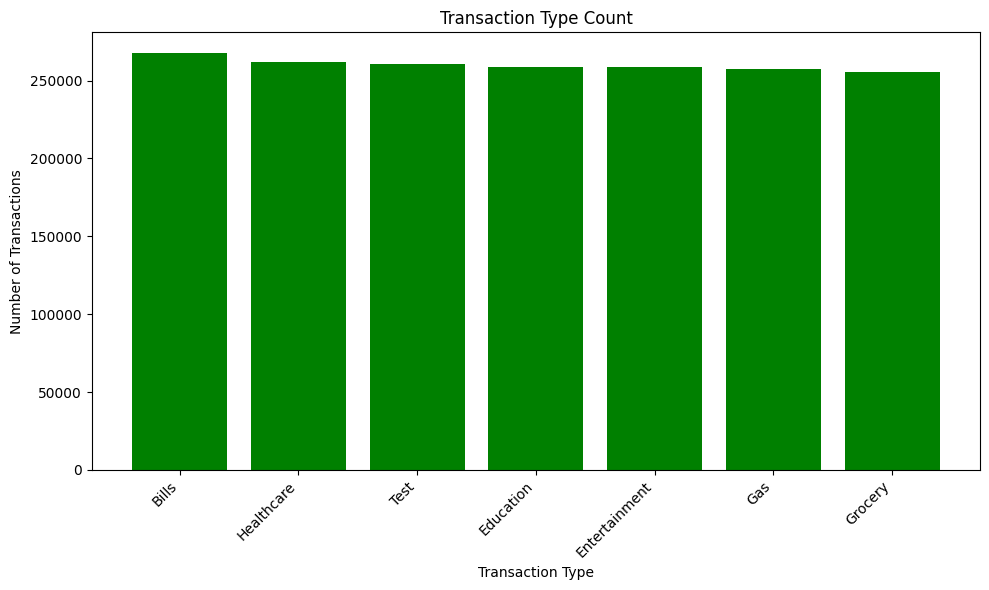

In [22]:
import mysql.connector # Lets you connect to and query a MySQL database
import pandas as pd # Used for data manipulation and to easily load SQL query results into a DataFrame
import matplotlib.pyplot as plt # Used to create the bar chart.

# Connect to database
conn = mysql.connector.connect( # Establishes a connection to MySQL database running on local machine.
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS count # Selects each unique TRANSACTION_TYPE # Counts how many times each type appears
FROM CDW_SAPP_CREDIT_CARD
GROUP BY TRANSACTION_TYPE # Groups the results by TRANSACTION_TYPE
ORDER BY count DESC; # Sorts them in descending order (most frequent first)
"""
credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df
conn.close() # Closes the database connection

plt.figure(figsize=(10, 6)) # Sets the figure size of the plot to 10 inches wide and 6 inches tall.

# Plot the bar chart
plt.bar(credit_db['TRANSACTION_TYPE'], credit_db['count'], color='green') # Creates a vertical bar chart. # The x-axis shows each TRANSACTION_TYPE. # The y-axis shows the corresponding count. # Bars are colored green.
plt.title('Transaction Type Count') # Adds a title and axis labels to the chart for better readability.
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')  # Rotates the x-axis labels by 45 degrees # Aligns them to the right (ha='right') to prevent overlapping if names are long.

plt.tight_layout() # Adjusts spacing to prevent elements from being cut off.
plt.show() # Displays the chart 


C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3599715590.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called credit_db


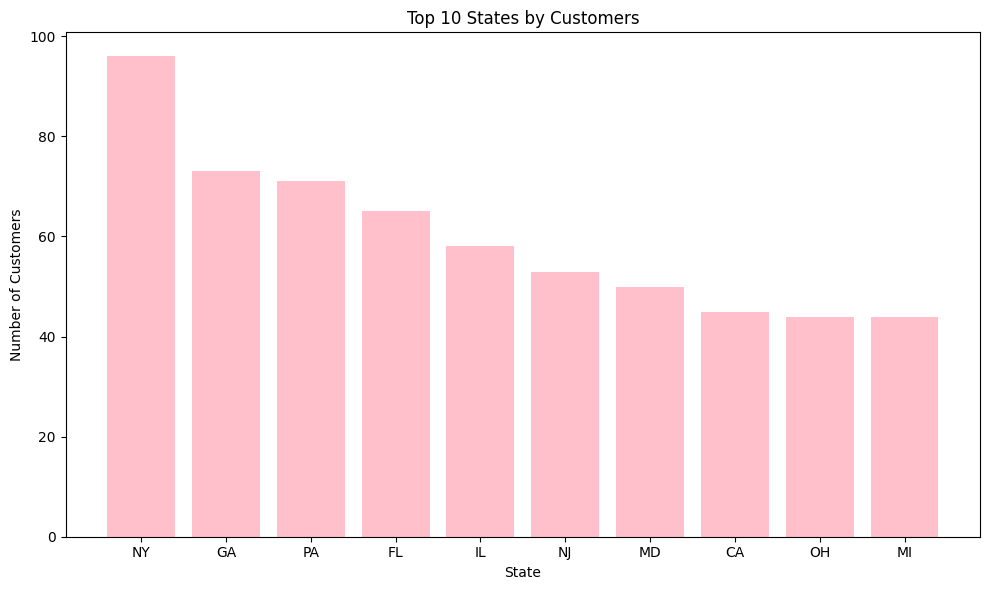

In [23]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt # Bar plot with matplotlib directly for more control

# Connect to the database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Query the database
query = """
SELECT CUST_STATE, COUNT(*) AS count
FROM CDW_SAPP_CUSTOMER
GROUP BY CUST_STATE
ORDER BY count DESC
LIMIT 10;
"""

credit_db = pd.read_sql(query, conn) # Executes the SQL query and loads the results into a pandas DataFrame called credit_db
conn.close()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6)) # Sets the figure size of the plot to 10 inches wide and 6 inches tall.
bars = ax.bar(credit_db['CUST_STATE'], credit_db['count'], color='pink') # Bars are colored pink 
plt.xticks(rotation=0)  # Rotating x-axis labels for better readability 

# Labeling
plt.xlabel('State') # Adding x-axis labels 
plt.ylabel('Number of Customers') # Adding y-axis labels
plt.title('Top 10 States by Customers') # Graph title 

plt.tight_layout()
plt.show() # Displaying the graph 


C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3692998774.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df3


    CUSTOMER_NAME  TOTAL_SPENT
0         Ty Daly    219689.73
1  Jessie Boucher    216377.46
2   Phoebe Martin    213567.12
3    Thurman Vera    207283.83
4    Bret Perkins    205180.17


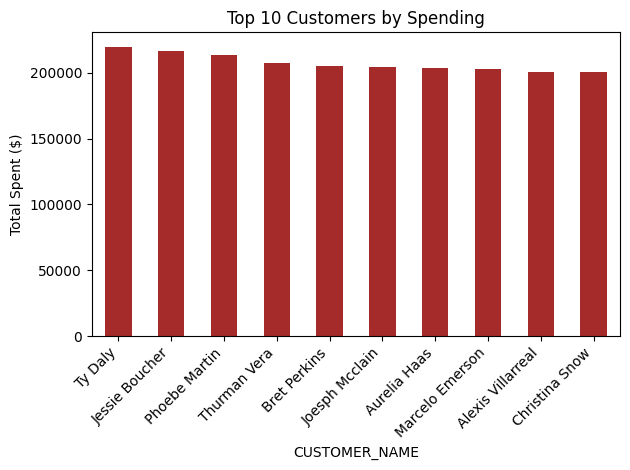

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Open connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Define query
query3 = """
SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS CUSTOMER_NAME, SUM(TRANSACTION_VALUE) AS TOTAL_SPENT
FROM CDW_SAPP_CREDIT_CARD AS cc
JOIN CDW_SAPP_CUSTOMER AS cu ON cc.CUST_SSN = cu.SSN
GROUP BY CUSTOMER_NAME
ORDER BY TOTAL_SPENT DESC
LIMIT 10;
"""

# Load data
df3 = pd.read_sql(query3, conn) # Executes the SQL query and loads the results into a pandas DataFrame called df3

# Preview
print(df3.head())

# Plot
df3.plot(kind='bar', x='CUSTOMER_NAME', y='TOTAL_SPENT', title='Top 10 Customers by Spending', color = 'Brown', legend=False) # Creates a bar chart with CUSTOMER_NAME on the x-axis and TOTAL_SPENT on the y-axis
plt.ylabel('Total Spent ($)')
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels by 45 degrees for better readability
plt.tight_layout()
plt.savefig("top_10_customers_by_spending")  # Saves the plot as an image file named "top_10_customers_by_spending.png"
plt.show()

# Close connection
conn.close()


### `Loading Loan Application Data API Into MySQL`

In [ ]:
import requests # Importing requests to get data from a web API 
from pyspark.sql import SparkSession # Importing SparkSession to create a Spark session

# Create Spark session
spark = SparkSession.builder \
    .appName("Loan Application ETL") \
    .getOrCreate() 


# Step 1: Read API data
response = requests.get("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")  # Fetches data from the specified URL (API endpoint) and stores it in response variable.

# Step 2: Print status code
print("Status Code:", response.status_code) # Displays the status code of the API response ( # 200 = success)

# Step 3: If OK, convert JSON to PySpark DataFrame and load to MySQL
if response.status_code == 200:  # Checks if the API request was successful (code 200)
    data = response.json()  # Converts the JSON response (text format) into a Python dictionary or list so it can be processed.

    # Step 4: Use existing Spark session (spark is already defined)
    # Step 5: Create Spark DataFrame from JSON data
    dataframe = spark.read.json(spark.sparkContext.parallelize(data)) # Converts the JSON data into a Spark DataFrame, which is a distributed collection of data organized into named columns.

    mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"  # MySQL database URL (host, port, and database name)

    mysql_properties = {
        "user": "root",               # MySQL username
        "password": "password",       # MySQL password
        "driver": "com.mysql.cj.jdbc.Driver"  # MySQL JDBC driver class name
    }

    # Step 6: Write to MySQL
    dataframe.write \
        .format("jdbc") \
        .option("url", mysql_url) \
        .option("dbtable", "CDW_SAPP_loan_application") \
        .option("user", mysql_properties["user"]) \
        .option("password", mysql_properties["password"]) \
        .option("driver", mysql_properties["driver"]) \
        .mode("overwrite") \
        .save()  # actually writes the data.

    print("Data loaded to MySQL!") # Indicates that the data has been successfully loaded into the MySQL database.
else:
    print("Failed to fetch data.") # Prints an error message if the API request was not successful.





Status Code: 200
Data loaded to MySQL!


### `Data Analysis & Visualization for Loan Application`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3057425890.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  credit_db = pd.read_sql(query, conn)


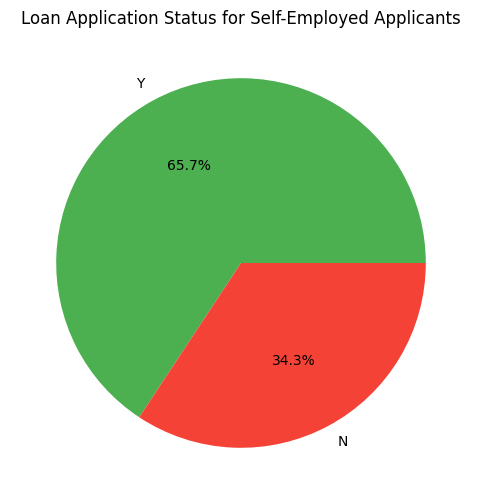

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Connect to the database
try:
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="password",        
        database="creditcard_capstone"
    )

    # Query to get loan application status by self-employment
    query = """
    SELECT Self_Employed, Application_Status
    FROM CDW_SAPP_LOAN_APPLICATION
    """

    # Load data into pandas DataFrame
    credit_db = pd.read_sql(query, conn)

finally:
    conn.close()

# Normalize casing to avoid mismatch
credit_db['Self_Employed'] = credit_db['Self_Employed'].str.strip().str.lower()
credit_db['Application_Status'] = credit_db['Application_Status'].str.strip().str.capitalize()

# Filter for self-employed applicants
self_employed = credit_db[credit_db['Self_Employed'] == 'yes']

# Count application statuses
status_counts = self_employed['Application_Status'].value_counts()

# Plot
plt.figure(figsize=(6, 6))
colors = ['#4CAF50', '#F44336']  # Green and red
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Loan Application Status for Self-Employed Applicants')
plt.savefig('self_employed_approval_percentage.png')  # Save as .png
plt.show()


## Credit Card Visualizations

### `Line Chart Visualization: Total credit card spending by month`

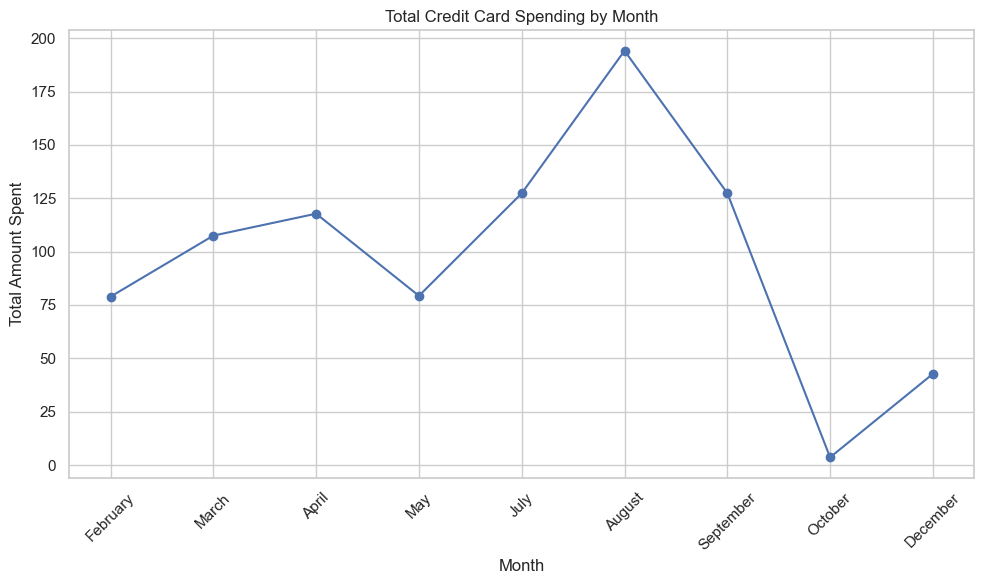

' \nThe line chart effectively visualizes the trend of credit card spending over the months, allowing for easy identification of spending patterns and seasonal variations.\n'

In [27]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting the bar chart
import seaborn as sns  # For enhanced visualization with seaborn
import calendar  # To convert month numbers to month names

sns.set(style="whitegrid")  # Set the style of seaborn plots to "whitegrid" for better aesthetics

# Credit card transaction data
credit_data = pd.DataFrame({
    "Month": [2, 3, 7, 4, 10, 5, 5, 8, 3, 9, 8, 12, 4, 4, 5, 7, 9],
    "Amount": [
        78.9, 14.24, 56.7, 59.73, 3.59, 6.89, 43.39, 95.39, 93.26, 100.38,
        98.75, 42.71, 40.24, 17.81, 29.0, 70.63, 27.04
    ]
})

# Group by month and sum the amounts
monthly_spending = credit_data.groupby("Month")["Amount"].sum().reset_index()

# Map month numbers to month names
monthly_spending["Month"] = monthly_spending["Month"].apply(lambda x: calendar.month_name[x]) # Converts month numbers (1-12) to month names (January, February, etc.) using calendar.month_name.

# Sort months in calendar order
monthly_spending["Month"] = pd.Categorical(
    monthly_spending["Month"],
    categories=list(calendar.month_name)[1:],  # Exclude empty string at index 0
    ordered=True
)
monthly_spending = monthly_spending.sort_values("Month") # Sorts the DataFrame by month names in calendar order, ensuring that the months are displayed correctly in the chart.

# Line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_spending["Month"], monthly_spending["Amount"], marker='o') # Plots a line chart with month names on the x-axis and total amounts spent on the y-axis. The marker='o' adds circular markers at each data point for better visibility.
plt.title("Total Credit Card Spending by Month") # Adds a title to the line chart.
plt.xlabel("Month")
plt.ylabel("Total Amount Spent")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show() # Displays the line chart showing total credit card spending by month.

""" 
The line chart effectively visualizes the trend of credit card spending over the months, allowing for easy identification of spending patterns and seasonal variations.
"""

### `Bar Chart Visualization: Spending by Category `

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3211082301.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_spending, x="Amount", y="Category", palette="viridis") # Creates a horizontal bar chart using seaborn's barplot function. The x-axis represents the total amount spent, and the y-axis represents the categories.


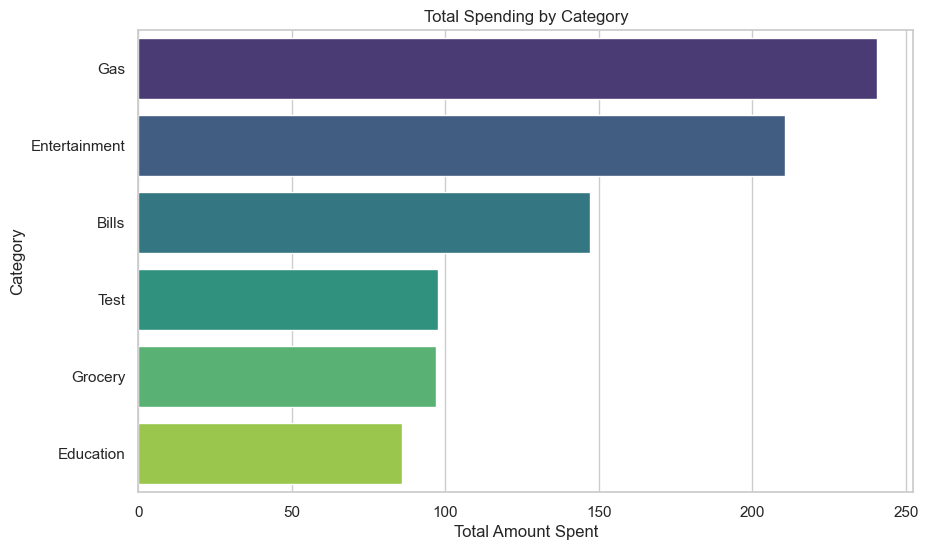

' The bar chart provides a clear comparison of spending across different categories, highlighting which categories have the highest total spending.\n'

In [28]:
# Category spending data 
credit_data["Category"] = [
    "Education", "Entertainment", "Grocery", "Entertainment", "Gas", "Education", "Entertainment",
    "Gas", "Entertainment", "Bills", "Gas", "Gas", "Grocery", "Bills", "Bills", "Test", "Test"
]

category_spending = credit_data.groupby("Category")["Amount"].sum().sort_values(ascending=False).reset_index() # Sorts the total spending by category in descending order and resets the index for better readability.

# Bar chart
plt.figure(figsize=(10, 6)) # Creates a new figure with a specified size of 10 inches wide and 6 inches tall.
sns.barplot(data=category_spending, x="Amount", y="Category", palette="viridis") # Creates a horizontal bar chart using seaborn's barplot function. The x-axis represents the total amount spent, and the y-axis represents the categories.
plt.title("Total Spending by Category") # Adds a title to the bar chart.
plt.xlabel("Total Amount Spent") # Adds a label to the x-axis.
plt.ylabel("Category") # Adds a label to the y-axis.
plt.show() # Displays the bar chart showing total spending by category.

""" The bar chart provides a clear comparison of spending across different categories, highlighting which categories have the highest total spending.
"""


### `Heatmap Visualization: Monthly Spending by Category`

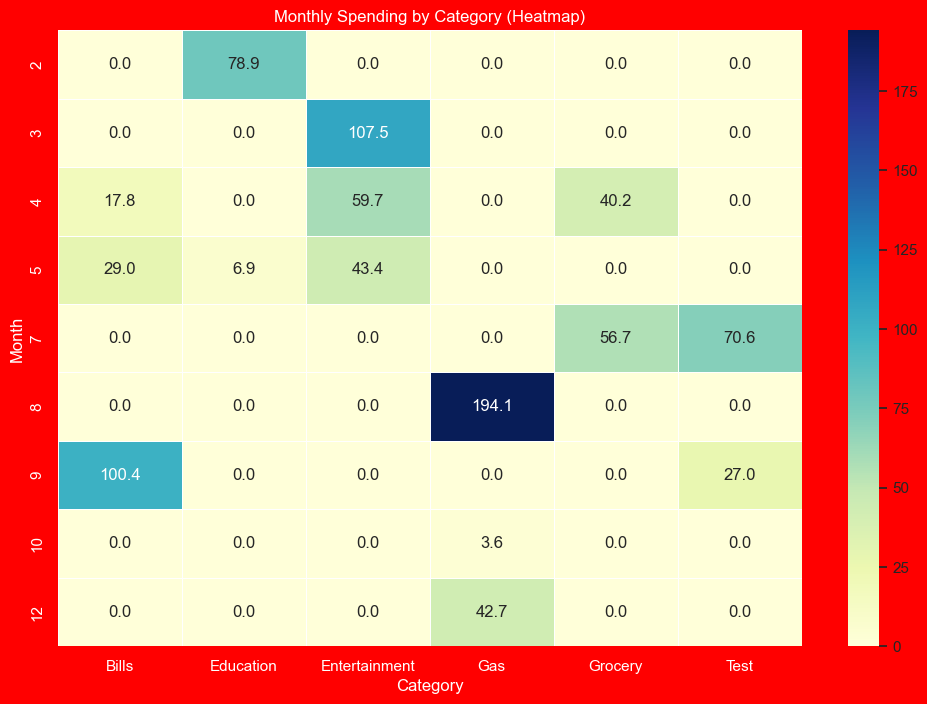

' The heatmap provides a visual representation of how spending varies across different categories and months, making it easy to identify trends and patterns in spending behavior.\n'

In [29]:
monthly_category = credit_data.groupby(["Month", "Category"])["Amount"].sum().unstack(fill_value=0) # Reshape the data to have months as rows and categories as columns, filling missing values with 0

# Heatmap
fig, ax = plt.subplots(figsize=(12, 8)) # Create a figure and axes for the heatmap
fig.patch.set_facecolor('red') # Set the background color of the figure to red 
ax.set_facecolor('red') # Set the background color of the axes to red
sns.heatmap(monthly_category, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, ax=ax)
plt.title("Monthly Spending by Category (Heatmap)", color='white') # Set the title color to white
plt.xlabel("Category", color='white') # Set the x-axis label color to white
plt.ylabel("Month", color = 'white') # Set the y-axis label color to white

ax.tick_params(colors='white') # Change the color of the tick labels to white
plt.show() # Displays the heatmap showing monthly spending by category with a red background.


""" The heatmap provides a visual representation of how spending varies across different categories and months, making it easy to identify trends and patterns in spending behavior.
"""


## Loan Application Visualizations

### `Loan Approval Rates by Income Bracket`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\3070440536.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


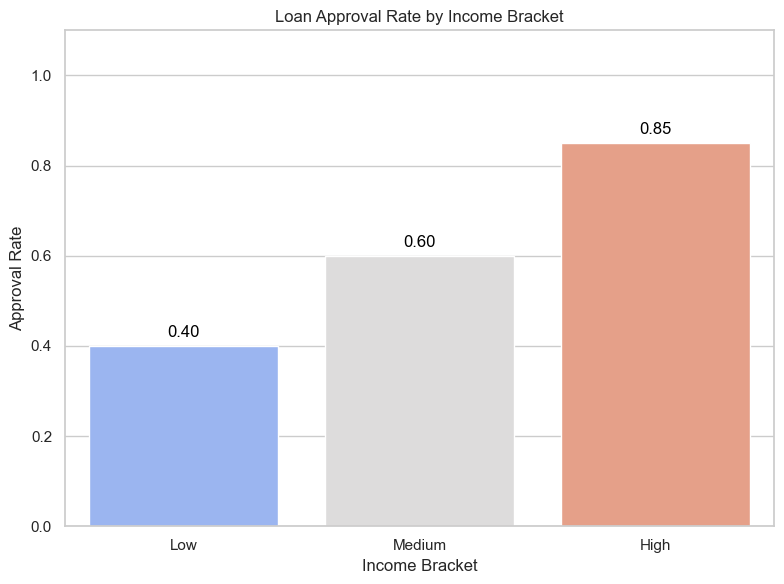

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Sample data (replace with your actual DataFrame)
income_loan = pd.DataFrame({
    'Income_Bracket': ['Low', 'Medium', 'High'],
    'Approval_Rate': [0.4, 0.6, 0.85]
})
# Set style
sns.set(style="whitegrid")
# Create the plot
plt.figure(figsize=(8, 6))
bar = sns.barplot(
    x="Income_Bracket",
    y="Approval_Rate",
    data=income_loan,
    palette="coolwarm"
)
# Add labels
for index, value in enumerate(income_loan["Approval_Rate"]):
    bar.text(index, value + 0.02, f"{value:.2f}", ha='center', color='black')
# Customize the plot
plt.title("Loan Approval Rate by Income Bracket")
plt.xlabel("Income Bracket")
plt.ylabel("Approval Rate")
plt.ylim(0, 1.1)
plt.tight_layout()
# Display it
plt.show()


### ``

### `Loan Approval by gender and Employment`

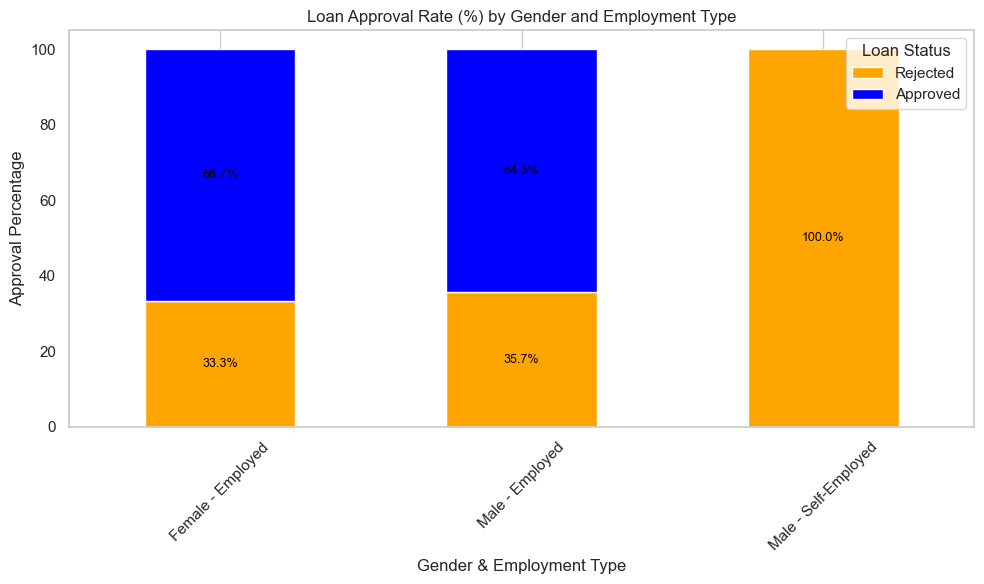

' The stacked bar chart provides a clear visual representation of loan approval rates\n'

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample loan application data
loan_data = pd.DataFrame({
    "Loan_Status": ['N', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y'], 
    "Self_Employed": ['Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
    "Gender": ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Male']         
})

# Clean and prepare data
loan_data["Loan_Status"] = loan_data["Loan_Status"].str.upper().str.strip() # Converts Loan_Status to uppercase and removes any leading/trailing whitespace.
loan_data["Self_Employed"] = loan_data["Self_Employed"].str.title().str.strip() # Converts Self_Employed to title case and removes any leading/trailing whitespace.
loan_data["Gender"] = loan_data["Gender"].str.title().str.strip()
loan_data["Employment_Type"] = loan_data["Self_Employed"].map({'No': 'Employed', 'Yes': 'Self-Employed'}) # Maps 'No' to 'Employed' and 'Yes' to 'Self-Employed' for better readability.
loan_data["Group"] = loan_data["Gender"] + " - " + loan_data["Employment_Type"] 

# Calculate approval/rejection percentages
grouped = loan_data.groupby(["Group", "Loan_Status"]).size().unstack(fill_value=0) # Groups the data by 'Group' and 'Loan_Status', counting occurrences, and fills missing values with 0.
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100 # Converts counts to percentages by dividing each count by the total count for that group and multiplying by 100.

# Plot stacked bar chart
ax = grouped_percent[['N', 'Y']].plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],
    figsize=(10, 6)
)

plt.title("Loan Approval Rate (%) by Gender and Employment Type") # Adds a title to the stacked bar chart.
plt.xlabel("Gender & Employment Type")
plt.ylabel("Approval Percentage")
plt.xticks(rotation=45)
plt.legend(title="Loan Status", labels=["Rejected", "Approved"])
plt.grid(axis='y') # Adds horizontal grid lines for better readability of the y-axis values.

# Add percentage labels on each stacked segment
for i, (index, row) in enumerate(grouped_percent.iterrows()):
    y_offset = 0
    for status in ['N', 'Y']:
        value = row[status]
        if value > 0:
            ax.text(i, y_offset + value / 2, f"{value:.1f}%", ha='center', va='center', fontsize=9, color='black') # Adds text labels to each segment of the stacked bar chart showing the percentage value with one decimal place.
            y_offset += value

plt.tight_layout()
plt.show()

""" The stacked bar chart provides a clear visual representation of loan approval rates
"""

### `Loan Rejection By Property Area`

C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\125971526.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\kashari.hutchins\AppData\Local\Temp\ipykernel_5148\125971526.py:42: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  bars = sns.barplot(


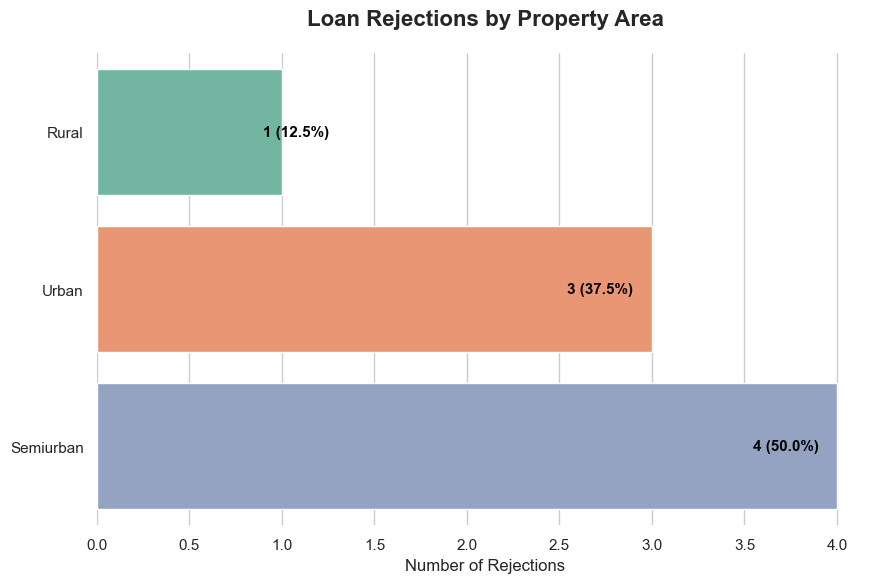

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input data
loan_status = ['N', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y']
property_area = [
    'Semiurban', 'Urban', 'Urban', 'Urban', 'Semiurban', 'Urban', 'Urban', 'Rural', 'Urban',
    'Semiurban', 'Rural', 'Semiurban', 'Rural', 'Semiurban', 'Semiurban', 'Urban', 'Rural', 'Urban'
]

# Create DataFrame
df = pd.DataFrame({
    "Loan_Status": loan_status,
    "Property_Area": property_area[:len(loan_status)]
})

# Filter rejected loans
rejections = df[df["Loan_Status"] == "N"]

# Count and percentage
rejection_counts = rejections["Property_Area"].value_counts().reindex(['Urban', 'Semiurban', 'Rural'])
rejection_percentages = (rejection_counts / rejection_counts.sum()) * 100

# Combine into single DataFrame
plot_df = pd.DataFrame({
    'Property_Area': rejection_counts.index,
    'Rejections': rejection_counts.values,
    'Percentage': rejection_percentages.values
})

# Sort for better visual flow
plot_df = plot_df.sort_values('Rejections')

# Plot setup
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(9, 6))

# Horizontal barplot
bars = sns.barplot(
    data=plot_df,
    y='Property_Area',
    x='Rejections',
    palette=palette,
    ax=ax
)

# Annotate inside bars
for i, (count, pct) in enumerate(zip(plot_df['Rejections'], plot_df['Percentage'])):
    ax.text(count - 0.1, i, f"{count} ({pct:.1f}%)",
            color='black', fontsize=11, fontweight='bold',
            va='center', ha='right' if count > 1 else 'left')

# Titles and labels
ax.set_title("Loan Rejections by Property Area", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Number of Rejections", fontsize=12)
ax.set_ylabel("")

# Clean up
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
